# Ungraded Lab: Using Convolutional Neural Networks

In this lab, you will look at another way of building your text classification model and this will be with a convolution layer. As you learned in Course 2 of this specialization, convolutions extract features by applying filters to the input. Let's see how you can use that for text data in the next sections.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import keras_nlp

## Download and prepare the dataset

In [2]:
# The dataset is already downloaded for you. For downloading you can use the code below.
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="../data/", download=False)

In [3]:
# Extract the train reviews and labels
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

# Extract the test reviews and labels
test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

In [4]:
# Download the subword vocabulary
!wget https://storage.googleapis.com/tensorflow-1-public/course3/imdb_vocab_subwords.txt

/usr/bin/sh: 1: wget: not found


In [5]:
# Initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./imdb_vocab_subwords.txt'
)

In [6]:
# Data pipeline and padding parameters
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 256
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [7]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), truncating=TRUNC_TYPE, padding=PADDING_TYPE)

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [8]:
# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

## Build the Model

In Course 2, you were using 2D convolution layers because you were applying it on images. For temporal data such as text sequences, you will use [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) instead so the convolution will happen over a single dimension. You will also append a pooling layer to reduce the output of the convolution layer. For this lab, you will use [GlobalMaxPooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) to get the max value across the time dimension. You can also use average pooling and you will do that in the next labs. See how these layers behave as standalone layers in the cell below.

In [9]:
# Parameters
BATCH_SIZE = 1
TIMESTEPS = 20
FEATURES = 20
FILTERS = 128
KERNEL_SIZE = 5

print(f'batch_size: {BATCH_SIZE}')
print(f'timesteps (sequence length): {TIMESTEPS}')
print(f'features (embedding size): {FEATURES}')
print(f'filters: {FILTERS}')
print(f'kernel_size: {KERNEL_SIZE}')

# Define array input with random values
random_input = np.random.rand(BATCH_SIZE,TIMESTEPS,FEATURES)
print(f'shape of input array: {random_input.shape}')

# Pass array to convolution layer and inspect output shape
conv1d = tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu')
result = conv1d(random_input)
print(f'shape of conv1d output: {result.shape}')

# Pass array to max pooling layer and inspect output shape
gmp = tf.keras.layers.GlobalMaxPooling1D()
result = gmp(result)
print(f'shape of global max pooling output: {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 20
filters: 128
kernel_size: 5
shape of input array: (1, 20, 20)
shape of conv1d output: (1, 16, 128)
shape of global max pooling output: (1, 128)


You can build the model by simply appending the convolution and pooling layer after the embedding layer as shown below.

In [10]:
# Hyperparameters
EMBEDDING_DIM = 64
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 64

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       488,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,049 (2.05 MB)

 Trainable params: 538,049 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

Training will take around 30 seconds per epoch and you will notice that it reaches higher accuracies than the previous models you've built.

In [12]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10


I0000 00:00:1725246751.127495     217 service.cc:145] XLA service 0x7f1e9007c2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725246751.127621     217 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6


 3/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5039 - loss: 0.6931 

I0000 00:00:1725246756.870784     217 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.6169 - loss: 0.6527 - val_accuracy: 0.8191 - val_loss: 0.4014
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8422 - loss: 0.3515 - val_accuracy: 0.8860 - val_loss: 0.2685
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9229 - loss: 0.2012 - val_accuracy: 0.8956 - val_loss: 0.2586
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9634 - loss: 0.1152 - val_accuracy: 0.8962 - val_loss: 0.2745
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9815 - loss: 0.0662 - val_accuracy: 0.8880 - val_loss: 0.3205
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9904 - loss: 0.0381 - val_accuracy: 0.8899 - val_loss: 0.3287
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9979 - loss: 0.0182 - val_accuracy: 0.8942 - val_loss: 0.3376
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9995 - loss: 0.0095 - val_accuracy: 0.8942 - val_loss: 

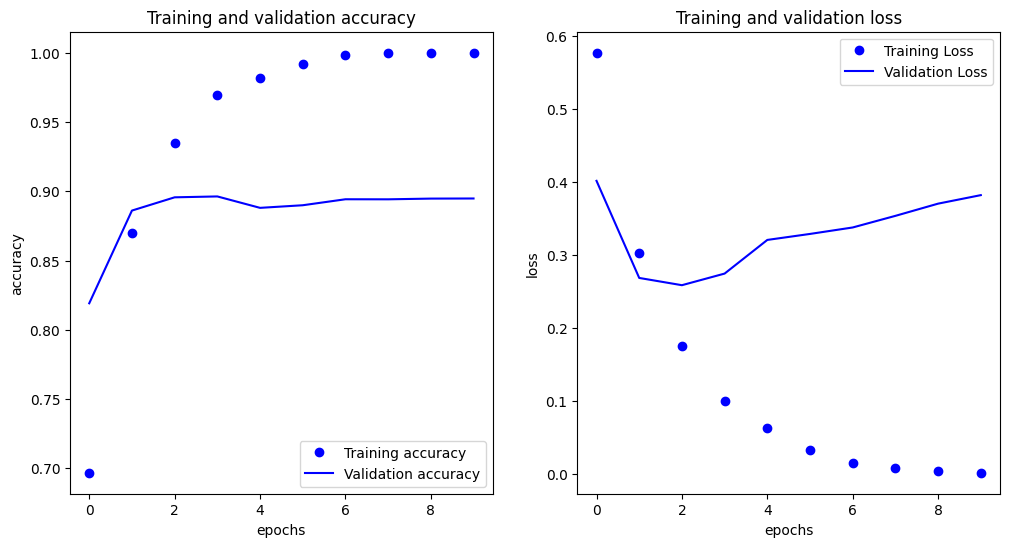

In [13]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

## Wrap Up

In this lab, you explored another model architecture you can use for text classification. In the next lessons, you will revisit full word encoding of the IMDB reviews and compare which model works best when the data is prepared that way.

As before, run the cell below to free up resources.

In [14]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}